# Intelligent Data Analysis Project
### Matej Bebej (50%), Marian Kurcina (50%)

## Table of Contents
- Assignment
- EDA
    - Information about the dataset
    - Preprocessing
    - Dataset split
- Code for training
    - Trainer
    - Dataloader
        - Transformations
        - Augmentations
    - Configs
- Model training
    - Experiment tracking
    - VGG-16
    - MobileNetV3-Large
    - EfficientNet
    - ResNet-18
    - Training evaluation
- Best model
- Conclusion

## Assignment

Create a model for age recognition that classifies a person into 3 age groups (old, middle, young) based on their face. First, do EDA, choose an appropriate ML/DL method and create the best model without overfitting or underfitting. 

## EDA 

### Information about the dataset

In [1]:
import pandas as pd
from PIL import Image
import hashlib
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Here we create a variable df (data frame) which contains data from train.csv. This file contains the name of the image (for  example 100.jpg) and to which group it belongs (old/ middle or young). We will modify our df so we can feed the images contained inside the dataframe to our models later on, but before that, we have to check for things such as duplicates and error files.

In [2]:
df = pd.read_csv('../Dataset/faces/train.csv')
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


From the following print, we can see the counts of images which belong to one of 3 given groups (young, middle, old). These groups are unbalanced, and because of that, we will have to use weights later in our model, so "rewarding" the model for guessing a class correctly isn't the same for every class. Also, we can see that the total number of images we are working with is 19906, which should be more than enough for most models to provide good and stable results.

In [3]:
df.Class.value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

In [4]:
#her we define the base path to the directory containing all the images
IMAGE_DIR = '../Dataset/faces/Train/'

Here we have brief code which showcases images we are working with. As we can see, they have different resolutions (axb), and therefore have different qualities. We believe some images with poor quality can impact our model in a wrong way, so we believe excluding them (for example images with smaller dimensions then 50) can provide us with better accuracy and overall model results.

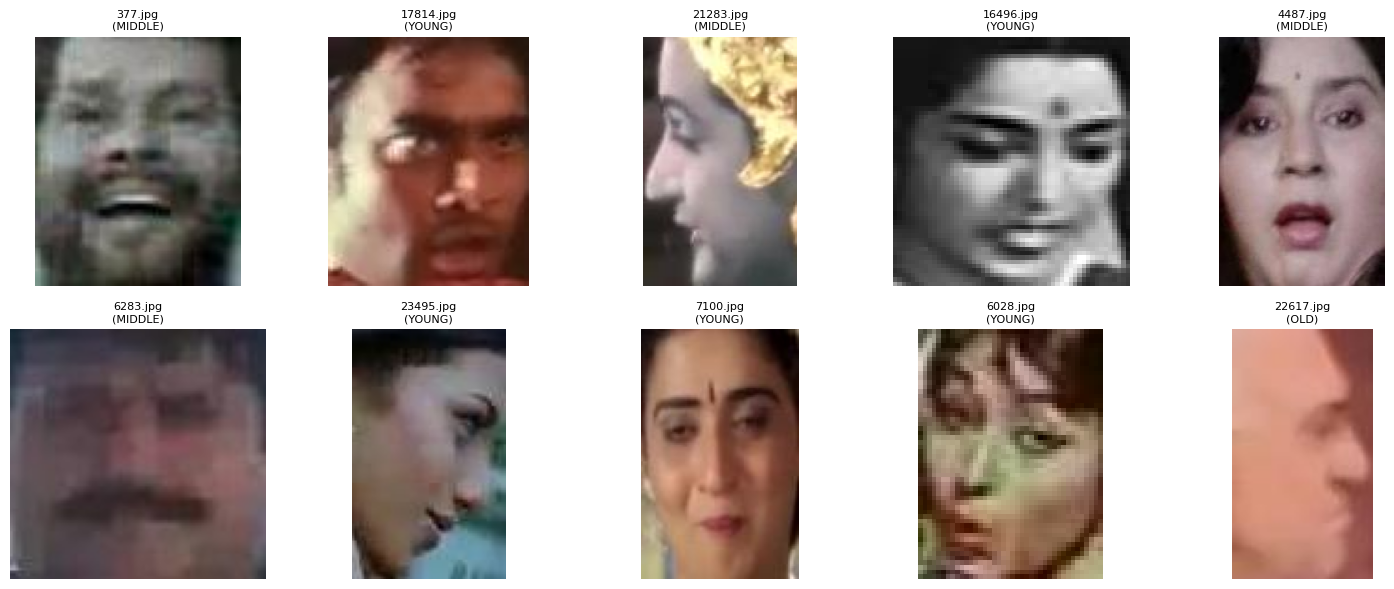

In [5]:
num_images_to_display = min(10, len(df))

cols = 5
rows = (num_images_to_display + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))


#iterate
for i, row in df.head(num_images_to_display).iterrows():
    image_id = row['ID']
    image_class = row['Class']
    image_path = os.path.join(IMAGE_DIR, image_id)

    img = Image.open(image_path)

    #display image itself
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)

    #add title
    plt.title(f"{image_id}\n({image_class})", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

To collect more information about the data we are working with, we drew a plot describing the distribution of different formats which are being used by our images. This information is important because in later stages, we plan on excluding images with poor quality. We believe that these images could impact our model in the wrong way.

Found 19906 JPG/JPEG files. Skipped 0 files (bad formats).


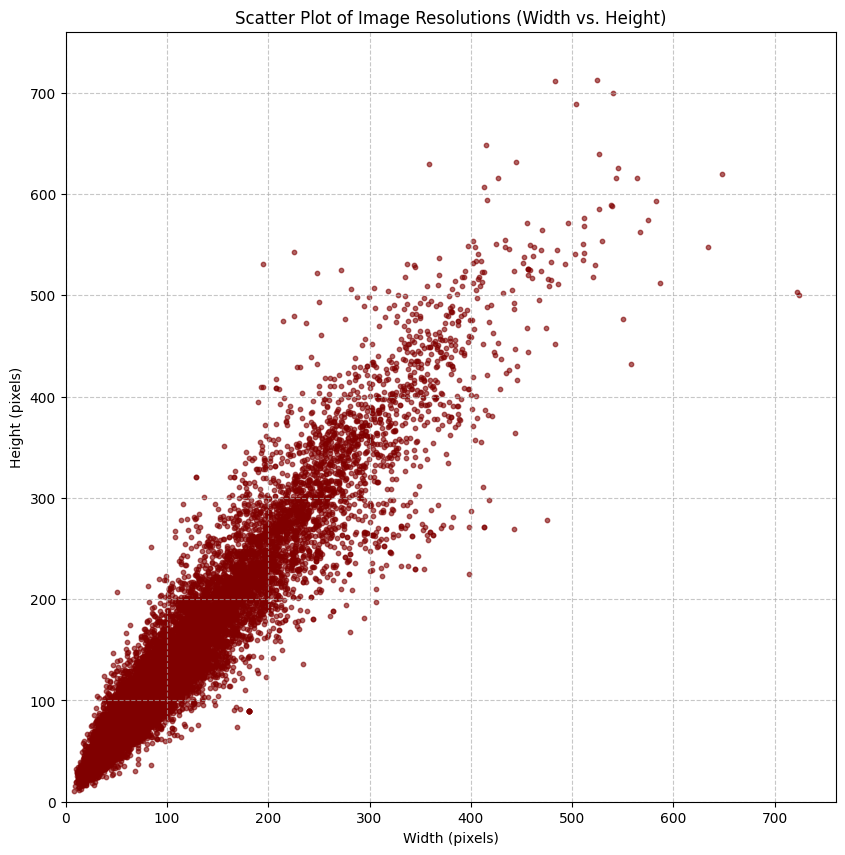

In [6]:
dimensions = []
error_count = 0
total_files_found = 0

try:
    for filename in os.listdir(IMAGE_DIR):
        #we work only with files containing JPEG/ JPG
        if filename.lower().endswith(('.jpg', '.jpeg')):
            image_path = os.path.join(IMAGE_DIR, filename)
            total_files_found += 1

            try:
                #open the image and get its size
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions.append({'Width': width, 'Height': height})
            except Exception:
                error_count += 1
                #we skip unreadable files

except FileNotFoundError:
    print(f"\nDirectory not found at {IMAGE_DIR}.")
    exit()

print(f"Found {total_files_found} JPG/JPEG files. Skipped {error_count} files (bad formats).")

dim_df = pd.DataFrame(dimensions)

if dim_df.empty:
    print("No dimensions could be determined for plotting.")
else:
    #generate Scatter Plot
    max_dim = max(dim_df['Width'].max(), dim_df['Height'].max())
    plt.figure(figsize=(10, 10))

    plt.scatter(
        dim_df['Width'],
        dim_df['Height'],
        s=10,
        alpha=0.6,
        color='maroon'
    )

    plt.xlim(0, max_dim * 1.05)
    plt.ylim(0, max_dim * 1.05)
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Scatter Plot of Image Resolutions (Width vs. Height)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

### Preprocessing

There are only 2 allowed image formats JPG and JPEG. Here we check for them and exclude any lines in df which have image with format other then those two. We do not only check the format inside the df but also inspect the format of the file itself, just to be sure.

In [7]:
keep_rows_format = pd.Series(True, index=df.index)

removed_format_count = 0

print(f"\nStarting format check on {len(df)} images...")

for index, row in df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(IMAGE_DIR, image_id)

    #check if the file extension is .jpg or .jpeg
    if not image_id.lower().endswith(('.jpg', '.jpeg')):
        #mark this row for deletion
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Removed non-JPG image: {image_id}")
        continue #skip

    try:
        #check the actual file format using PIL
        with Image.open(image_path) as img:
            if img.format not in ('JPEG', 'JPG'):
                keep_rows_format.loc[index] = False
                removed_format_count += 1
                print(f"Removed file with wrong internal format: {image_id} (Internal format: {img.format})")

    except FileNotFoundError:
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Warning: Image file not found during format check: {image_id}. Deleting row.")

    except Exception as e:
        keep_rows_format.loc[index] = False
        removed_format_count += 1
        print(f"Error checking format for image {image_id}: {e}. Deleting row.")


#update the main df
df = df[keep_rows_format]

print(f"total non-JPG images found and removed: {removed_format_count}")
print(f"new DataFrame size after format check: {len(df)}")


Starting format check on 19906 images...
total non-JPG images found and removed: 0
new DataFrame size after format check: 19906


In following code we check for any duplicates. We have successfully found almost 300 duplicates, which is not a lot, but we think it would still have a negative effect on the model and its training, validation and testing, so we "get rid of them". We do not delete any files here, or at any steps in this code, we just  get rid of thier mentions in our data frame - df. Later on we will copy remaining images which will remain after numerous EDA tests, and work with those in our model.

In [8]:
HASH_ALGORITHM = 'md5'
BLOCKSIZE = 65536

print(f"Starting duplicate check in: {IMAGE_DIR}")

first_instance_hashes = {}

files_to_remove = []

total_files_checked = 0

#iterate and check for duplicates

try:
    for filename in os.listdir(IMAGE_DIR):
        image_path = os.path.join(IMAGE_DIR, filename)

        hasher = hashlib.new(HASH_ALGORITHM)

        try:
            #read file in chunks to get the hash
            with open(image_path, 'rb') as file:
                buffer = file.read(BLOCKSIZE)
                while len(buffer) > 0:
                    hasher.update(buffer)
                    buffer = file.read(BLOCKSIZE)

            file_hash = hasher.hexdigest()
            total_files_checked += 1

            #finding duplicates for removal
            if file_hash in first_instance_hashes:
                #found one
                files_to_remove.append(filename)
            else:
                first_instance_hashes[file_hash] = filename

        except Exception as e:
            print(f"Warning: Could not process file {filename} for hashing: {e}.")

except FileNotFoundError:
    print(f"\nERROR: Directory not found at {IMAGE_DIR}. Cannot check for duplicates.")
    exit()

if files_to_remove:
    print(f" There are duplicates, number of files marked for removal from df: {len(files_to_remove)}")


    initial_df_size = len(df)

    #create the filter mask: True for rows to KEEP, False for rows to REMOVE
    keep_rows_mask = ~df['ID'].isin(files_to_remove)# je tam negacia takze keep tie ktore NIE su v files to remove

    #df becomes without duplicates
    df = df[keep_rows_mask]

    print(f"Original DataFrame size: {initial_df_size}")
    print(f"New DataFrame size after removing duplicates: {len(df)}")

else:
    print("\nno exact duplicate image files were found")

Starting duplicate check in: ../Dataset/faces/Train/
 There are duplicates, number of files marked for removal from df: 291
Original DataFrame size: 19906
New DataFrame size after removing duplicates: 19615


We mentioned before, that we believe that images with extremely low dimensions (axb) quality can lower ability of our model to successfully classify face as old, young or middle age. In current code we set MIN_DIMENSION parameters as 50, later on if we have time to do so, we would like to make experiment where we will change this variable and try to determine if it has any effect at all, and if this stap was even necessary. By using our variable MIN_DIMENSION set to 50 (50x50 at least) we have excluded more the 6000 images, which we know is a lot, but we think 13000 is still more then enough for successful model training and testing.

In [9]:
#set an index list of rows to KEEP (initialized to all rows)
keep_rows = pd.Series(True, index=df.index)

MIN_DIMENSION = 1
small_image_count = 0



print(f"starting with {len(df)} rows. Filtering for images smaller than {MIN_DIMENSION}x{MIN_DIMENSION}")

#iterate through each row of the DataFrame df
for index, row in df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(IMAGE_DIR, image_id)

    try:
        #open the image using the its full path
        with Image.open(image_path) as img:
            width, height = img.size

            #check if dimensions meet our requirement - MIN_DIMENSION
            if width < MIN_DIMENSION or height < MIN_DIMENSION:
                #mark this row for deletion (keep flag - False)
                keep_rows.loc[index] = False
                small_image_count += 1

    except FileNotFoundError:
        print(f"image file not found at {image_path}")

    except Exception as e:
        print(f"Error processing image {image_id}: {e}")
        keep_rows.loc[index] = False

#a the filter to the DataFrame
df_filtered = df[keep_rows]

print(f"Total small images found and removed: {small_image_count}")
print(f"Original DataFrame size: {len(df)}")
print(f"New DataFrame size: {len(df_filtered)}")
print("\nfirst 5 rows of the filtered DataFrame:")
print(df_filtered.head())

df = df_filtered

starting with 19615 rows. Filtering for images smaller than 1x1
Total small images found and removed: 0
Original DataFrame size: 19615
New DataFrame size: 19615

first 5 rows of the filtered DataFrame:
          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


Now for the filtered dataset we need to get the average dimensions so we can do the optimal resizing later. 

In [10]:
all_widths = []
all_heights = []
for index, row in df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(IMAGE_DIR, image_id)

    try:
        #open the image using the its full path
        with Image.open(image_path) as img:
            width, height = img.size
            
            # collect dimensions
            all_widths.append(width)
            all_heights.append(height)
            
    except FileNotFoundError:
        print(f"image file not found at {image_path}")

    except Exception as e:
        print(f"Error processing image {image_id}: {e}")
        
avg_width = sum(all_widths) / len(all_widths)
avg_height = sum(all_heights) / len(all_heights)

print(f"\nAverage width: {avg_width:.2f}px")
print(f"Average height: {avg_height:.2f}px")
    


Average width: 98.81px
Average height: 125.48px


Here we do just a simple test that there is no line in our df dataframe, which contains class outside of 3 allowed ones ['MIDDLE', 'OLD', 'YOUNG']. Again same as with formats there are no records in df which we found are defective, but these test are necessary if the given dataset isnt as "prepared", adn we have to do them just in case, so the model has no defective files given to it.

In [11]:
ALLOWED_CLASSES = ['MIDDLE', 'OLD', 'YOUNG']

print(f"Starting class validation on {len(df)} rows...")

is_allowed = df['Class'].isin(ALLOWED_CLASSES)
df_class_filtered = df[is_allowed]

removed_class_count = len(df) - len(df_class_filtered)

#update the main df reference
df = df_class_filtered

print(f"Original DataFrame size: {len(df) + removed_class_count}")
print(f"Rows with invalid 'Class' removed: {removed_class_count}")
print(f"New DataFrame size: {len(df)}")
print("\nNew value counts for 'Class' column:")
print(df['Class'].value_counts())

Starting class validation on 19615 rows...
Original DataFrame size: 19615
Rows with invalid 'Class' removed: 0
New DataFrame size: 19615

New value counts for 'Class' column:
Class
MIDDLE    10581
YOUNG      6647
OLD        2387
Name: count, dtype: int64


### Dataset split

Last step in our preprocessing it so split our already filtered data to 3 groups which will be used for training, testing and validation. We have decided to use ration 8:1:1, because we think it will porvide us with enough images in each set, necessary to train and evaluate our model. The ratio of images in OLD, MIDDLE and YOUNG classes still remains the same thanks to: stratify=df, but later on we will have to use weighted evaluation for different classes. For each split we create separate folder and all 3 new split folders (train, valid and test) are located inside newly created folder which is determined at the start of the code in OUTPUT_BASE_DIR, in our case folder Dataset_Split. We will use this folder and its content to work with model. We fill these new folders by copying images, we dont delete no images we are given at the start.

In [12]:
OUTPUT_BASE_DIR = '../Dataset_Split/'
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#we use 'stratify=df["Class"]' to ensure the class distribution is maintained in the split.
df_train_val, df_test = train_test_split(
    df,
    test_size=TEST_RATIO,
    random_state=42,
    stratify=df['Class']
)

#now, split the remaining data (df_train_val) into training (80%) and validation (10%).
#the validation set size is 0.1 / 0.9 = ~0.1111 of the df_train_val set.
val_size_relative = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

df_train, df_val = train_test_split(
    df_train_val,
    test_size=val_size_relative,
    random_state=42,
    stratify=df_train_val['Class']
)

#we create a dictionaries of the final data splits
data_splits = {
    'train': df_train,
    'valid': df_val,
    'test': df_test
}

print("Split Sizes and Class Distribution Check:")
for name, split_df in data_splits.items():
    print(f"  {name.upper()} Set Size: {len(split_df)} images.")
    print(f"  {name.upper()} Class Counts:\n{split_df['Class'].value_counts()}\n")


#to not add into the dictory if it already exists, we always start fresh with new one
if os.path.exists(OUTPUT_BASE_DIR):
    shutil.rmtree(OUTPUT_BASE_DIR)

os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

#iterate through each split
for split_name, split_df in data_splits.items():
    print(f"Processing {split_name} set")

    #iterate through each row in the split's DataFrame
    for index, row in split_df.iterrows():
        image_id = row['ID']
        image_class = row['Class']

        target_dir = os.path.join(OUTPUT_BASE_DIR, split_name, image_class)
        os.makedirs(target_dir, exist_ok=True) # Create folder if it doesn't exist

        source_path = os.path.join(IMAGE_DIR, image_id)
        target_path = os.path.join(target_dir, image_id)

        try:
            #copy the image file
            shutil.copy(source_path, target_path)
        except FileNotFoundError:
            print(f"image not found at {source_path}")

print(f"training, validation, and test images are now organized in: {OUTPUT_BASE_DIR}")

Split Sizes and Class Distribution Check:
  TRAIN Set Size: 15691 images.
  TRAIN Class Counts:
Class
MIDDLE    8465
YOUNG     5317
OLD       1909
Name: count, dtype: int64

  VALID Set Size: 1962 images.
  VALID Class Counts:
Class
MIDDLE    1058
YOUNG      665
OLD        239
Name: count, dtype: int64

  TEST Set Size: 1962 images.
  TEST Class Counts:
Class
MIDDLE    1058
YOUNG      665
OLD        239
Name: count, dtype: int64

Processing train set
Processing valid set
Processing test set
training, validation, and test images are now organized in: ../Dataset_Split/


The dataset contains labelled images, where classification is based on visual features; therefore, we have chosen convolutional neural networks as the modelling strategy. 
To reduce overfitting, anti-overfitting techniques will be introduced, such as strong augmentations, adding dropout and freezing layers, and weight decay, label smoothing and early stopping. The best model should not be overfitted or underfitted. We have defined that the best model will be the model with the best accuracy while having the difference between train and validation accuracy being under 4%. This way the model won't be overfitted or underfitted.

## Code for training

For our training we have decided to use 2 scripts, trainer and dataloader. We have also one helping script to create configs. 

### Trainer

In this script, the main training of the model takes place. First, all configs to be tested are loaded to give the training individual parameters. The model is loaded based on the configuration, and dataloaders are created. If the  user specifies to use Weights and Biases for training tracking the parameters of the run are configured.        
After that Loss function with label smoothing and class weights, label smoothing can help with overfitting and class weights contain the distribution of classes. This helps when the classes are imbalanced, which we have determined earlier in EDA.               
For optimiser, we have decided to use Adam with weight decay, since in the past it worked best for us, and it can reduce overfitting.                  
We use the CosineAnnealingLR scheduler, this scheduler gradually decays the learning rate. At the beginning, it has the highest value, and at the end, it has the lowest value.                    
During our training, we save the best performing model; this model is the best when it has the highest validation accuracy during the run.                               
After each epoch is trained, the model is evaluated for val_loss and val_acc, which are then logged in Wandb together with train_loss and train_acc. If the val_acc is the best yet, the model is saved as best yet. If there is no improvement in val_acc for a determined number of epochs, the training is terminated.                          
After training, the best model is loaded and evaluated using all the train, val and test datasets. Lastly, the confusion matrix is generated and logged into Wandb.                       
The process continues for each config file defined inside the config folder; this allows for long-time unattended training.              

### Dataloader

Next script is Dataloader script. This script prepares the dataset from the splited folders.             
First the transformations are defined for each dataset, for train dataset the augmentations are performed to reduce overfitting. For validation and test datasets the resizing and normalization are performed. Normalization is performed based on recorded distribution: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2          
After this the datasets are loaded from the folders and dataloader are created right after.

#### Transformations

For transformations, we use:

```
test_tfms = transforms.Compose([

        transforms.Resize((125, 99)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            
        ),
    ])
```

We resize to the average dimensions of the filtered dataset, which has proven to give a slightly better performance of the models.
After that, we convert the image to a tensor and, lastly, normalise each pixel. We use mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], which are calculated based on millions of images and should make the model better. For our dataset, we could calculate our own distribution, which should further optimise model performance.

#### Augmentations

We have added augmentations for our training data to reduce overfitting:

```
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomAffine(
        degrees=20,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
),
transforms.RandomPerspective(distortion_scale=0.15, p=0.3),
transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02
),
```

During our training, we have tried out training with fewer augmentations, which has led to overfitting.

### Configs 

To make long-lasting training sessions possible without attendance, we have used config-based training. For each run new config is loaded. The config files structure:

```
{
    "dataset_path": "../Dataset_Split",
    "model": "ResNet18",
    "batch_size": 64,
    "num_workers": 4,
    "use_wandb": true,
    "wandb_project": "age",
    "wandb_entity": "IAU_2025",
    "wandb_log_frequency": 500,
    "weight_decay": 0.001,
    "label_smoothing": 0.1,
    "early_stop_patience": 7,
    "epochs": 100,
    "lr": 0.001,
    "wandb_run_name": "ResNet18_run_001",
    "out_dir": "../runs/ResNet18_run_001"
}
```

For grid search, we have implemented a create config code which creates all possible combinations of configs needed. 

## Model training

For our model training, we have decided to evaluate model overfitting based on the graphs and the difference between training and validation accuracy. We have decided to accept a difference of 4% between the validation and training accuracy.

### Experiment tracking

For experiment tracking, we use Weights & Biases (Wandb). Running the trainer initialises a new Wandb run, using metadata from the config file.
For each run, we log the following metrics for the best model:

- f1_weighted,
- precision_weighted,
- recall_weighted,
- precision_macro,
- accuracy,
- confusion_matrix,
- classification_report


<figure>
  <img src="Resources/img1.png" alt="Wandb environment">
  <figcaption>Image 1: Wandb environment.</figcaption>
</figure>


<figure>
  <img src="Resources/img2.png" alt="Graphs">
  <figcaption>Graph 1: Graphs in Wandb.</figcaption>
</figure>


### VGG-16

First, we have chosen to test with the VGG-16 model.      
We have performed only one run; the model was too large for our case, so we have abandoned it.


<figure>
  <img src="Resources/img3.png" alt="VGG-16 run">
  <figcaption>Graph 2: VGG-16 run.</figcaption>
</figure>


### MobileNetV3-Large

Next, we have tried a smaller model called MobileNetV3-Large. We have performed 4 runs with different numbers of epochs and with/without dropout before the classifier, with different dropouts.

This model was able to reach a validation accuracy of only 0.89 with higher overfitting, while using all anti-overfitting techniques. Since we were able to get the same performance with less overfitting with the next two models, we have decided not to continue with this model. The best acceptable model has a validation accuracy of 0.819 and a training accuracy of 0.821.


<figure>
  <img src="Resources/img4.png" alt="MobileNetV3-Large run">
  <figcaption>Graph 3: MobileNetV3-Large run.</figcaption>
</figure>


#### Evaluation of the best model

Model and training configuration:

|                        |                             |
|------------------------|-----------------------------|
| model                  | MobileNetV3-Large           |
| batch_size             | 64                          |
| weight_decay           | 0.001                       |
| label_smoothing        | 0.1                         |
| early_stop_patience    | 10                          |
| epochs                 | 20                          |
| lr                     | 0.001                       |
| Images used            | all (without duplicates)    |
| Additional info        | classifier with 0.5 dropout |

Model evaluation:

| Metric                         | Value |
|--------------------------------|-------|
| Train Loss                     | 0.656 |
| Train Accuracy                 | 0.821 |
| Validation Loss                | 0.784 |
| Validation Accuracy            | 0.819 |
| Test Loss                      | 0.782 |
| Test Accuracy                  | 0.799 |
| Test F1-score                  | 0.798 |
| Test Precision                 | 0.812 |
| Test Recall                    | 0.799 |

### EfficientNet

Here, we have attempted several experiments with model called EfficientNet. We have performed 12 runs with different numbers of epochs and with/without dropout before the classifier, with different dropouts, with different samples of images, different resizing and learning rate.

Grid search with model EfficientNet-B0

<figure>
  <img src="Resources/img9.png" alt="Comparison of all our models configuration in grid search only with their train accuracy">
  <figcaption>Graph 4: Comparison of all our models configuration in grid search with their train and validation accuracy.</figcaption>
</figure>

<figure>
  <img src="Resources/img10.png" alt="Comparison of all our models' configuration in grid search only with their validation accuracy">
  <figcaption>Graph 5: Comparison of all our models' configurations in grid search with their train and validation accuracy.</figcaption>
</figure>


This model was able to reach a validation accuracy of only 0.902 with higher overfitting (around 7% difference between training and validation accuracy). Later experiments contain more anti-overfit mechanisms such as freezing layers, stronger augmentation and dropout we have received similar results with lower overfit, less than 6% difference. This model we even display later on, because it fits into the mild-overfit category.

<figure>
  <img src="Resources/img5.png" alt="EfficientNet best accuracy">
  <figcaption>Graph 6: EfficientNet best accuracy.</figcaption>
</figure>


With more tests, we have reached an overfit as low as 2%, but with a validation accuracy under 0.84. This run can be seen in graph 7. 

<figure>
  <img src="Resources/img6.png" alt="EfficientNet lowest overfit">
  <figcaption>Graph 7: EfficientNet lowest overfit.</figcaption>
</figure>

We have decided to pick a model with higher accuracy as well as an acceptable difference between validation and training accuracy, which is around 4%. The validation accuracy for this model was 0.863, with training accuracy of 0.904. We display this run in Graph 8.

<figure>
  <img src="Resources/img7.png" alt="EfficientNet best model">
  <figcaption>Graph 8: EfficientNet best model.</figcaption>
</figure>


We have chosen this model as the best EfficienNet-B0 model.

#### Evaluation of the best model

Model and training configuration:

|                     |                                          |
|---------------------|------------------------------------------|
| model               | EfficientNet-B0                          |
| batch_size          | 64                                       |
| weight_decay        | 0.001                                    |
| label_smoothing     | 0.1                                      |
| early_stop_patience | 10                                       |
| epochs              | 30                                       |
| best epoch          | epoch 27                                 |
| lr                  | 0.001                                    |
| Images used         | resolution at least 50 - 13000 images    |
| Additional info     | no augmentations used                    |


Model evaluation:

| Metric                         | Value |
|--------------------------------|-------|
| Train Loss                     | 0.545 |
| Train Accuracy                 | 0.904 |
| Validation Loss                | 0.724 |
| Validation Accuracy            | 0.863 |
| Test Loss                      | 0.715 |
| Test Accuracy                  | 0.869 |
| Test F1-score                  | 0.856 |
| Test Precision                 | 0.870 |
| Test Recall                    | 0.861 |

### ResNet-18

The next model we tried was ResNet-18. We first performed a grid search to find the best learning rate and number of epochs. We have found that the best performing learning rate was 0.001 with a high number of epochs; therefore, we have decided to use this for our further experimentations.


<figure>
  <img src="Resources/img11.png" alt="ResNet-18 grid search - train accuracy">
  <figcaption>Graph 9: ResNet-18 grid search - train accuracy.</figcaption>
</figure>

<figure>
  <img src="Resources/img12.png" alt="ResNet-18 grid search - validation accuracy">
  <figcaption>Graph 10: ResNet-18 grid search - validation accuracy.</figcaption>
</figure>

Next, we have added a dropout before the classifier to lower the overfitting. We have tested with different dropouts and classifier widths; the best performing model was with a classifier defined as:

```
MODEL.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(MODEL.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )
```

<figure>
  <img src="Resources/img13.png" alt="ResNet-18 with dropout before classifier">
  <figcaption>Graph 11: ResNet-18 with dropout before classifier.</figcaption>
</figure>

This model had a validation accuracy of 0.8960 while having a train accuracy of 0.9411, which is mild overfitting. Because of that, we have tried to reduce overfitting by introducing a new optimisation for overfitting.

We have decided to try introducing layer freezing, with a different number of first layers freezing. The freezing of 1 layer has improved our model overfitting; with 2-layer freezing, the improvement was insignificant. With the first layer frozen, we were able to get a model with low overfitting, with validation accuracy of 0.882 and train accuracy of 0.919.

<figure>
  <img src="Resources/img14.png" alt="ResNet-18 with first layer freezing">
  <figcaption>Graph 12: ResNet-18 with first layer freezing.</figcaption>
</figure>

We have determined that this is the best low-overfitting ResNet-18 model.

During the search for the best ResNet-18 model, we have performed 55 runs.

<figure>
  <img src="Resources/img15.png" alt="ResNet-18 runs - train accuracy">
  <figcaption>Graph 13: ResNet-18 runs - train accuracy.</figcaption>
</figure>

<figure>
  <img src="Resources/img16.png" alt="ResNet-18 runs - validation accuracy">
  <figcaption>Graph 14: ResNet-18 runs - validation accuracy.</figcaption>
</figure>

#### Evaluation of the best model

Model and training configuration:

|                        |                             |
|------------------------|-----------------------------|
| model                  | ResNet-18                   |
| batch_size             | 64                          |
| weight_decay           | 0.001                       |
| label_smoothing        | 0.1                         |
| early_stop_patience    | 10                          |
| epochs                 | 100 (early stopping in 74)  |
| lr                     | 0.001                       |
| Images used            | all (without duplicates)    |
| Additional info        | classifier with 0.5 dropouts|
|                        | First layer freezing        |

Model evaluation:

| Metric                         | Value |
|--------------------------------|-------|
| Train Loss                     | 0.520 |
| Train Accuracy                 | 0.919 |
| Validation Loss                | 0.709 |
| Validation Accuracy            | 0.881 |
| Test Loss                      | 0.710 |
| Test Accuracy                  | 0.879 |
| Test F1-score                  | 0.872 |
| Test Precision                 | 0.872 |
| Test Recall                    | 0.873 |

### Training evaluation

|                        |                   |              |            |
|------------------------|-------------------|--------------|------------|
| model                  | MobileNetV3-Large | EfficientNet | ResNet-18  | 
| Train Loss             | 0.656             | 0.545        | 0.520      |
| Train Accuracy         | 0.821             | 0.904        | 0.919      |
| Validation Loss        | 0.784             | 0.724        | 0.709      |
| Validation Accuracy    | 0.819             | 0.863        | 0.881      |
| Test Loss              | 0.782             | 0.715        | 0.710      |
| Test Accuracy          | 0.799             | 0.869        | 0.879      |
| Test F1-score          | 0.798             | 0.856        | 0.872      |
| Test Precision         | 0.812             | 0.870        | 0.872      |
| Test Recall            | 0.799             | 0.861        | 0.873      |

For each model architecture we present the best model, all of them are stable, with test accuracy being simmilar to validation accuracy. The training processes can be seen in the Graphs 15-17.

<figure>
  <img src="Resources/img17.png" alt="Best run - MobileNetV3-Large">
  <figcaption>Graph 15: Best run - MobileNetV3-Large.</figcaption>
</figure>

<figure>
  <img src="Resources/img18.png" alt="Best run - EfficientNet">
  <figcaption>Graph 16: Best run - EfficientNet.</figcaption>
</figure>

<figure>
  <img src="Resources/img19.png" alt="Best run - ResNet-18">
  <figcaption>Graph 17: Best run - ResNet-18n.</figcaption>
</figure>


### Best model

The best model we have selected is ResNet architecture with weight_decay of 0.001, label_smoothing of 0.1, early_stop_patience of 10, number of epochs 100 (with early stopping accuring in epoch 74) and learning rate of 0.001. The model has first layer freezed and decay before classifier of 0.5 and classifier having width of 128, which can be seen below: 

```
MODEL = models.resnet18(weights=None)
        for param in MODEL.conv1.parameters():
            param.requires_grad = False
        MODEL.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(MODEL.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )
```

This model has validation accuracity of 0.881, test accuracity of 0.879 and training accuracity of 0.919. The f-1 of 0.872, precision of 0.872 and recall of 0.873. 

<figure>
  <img src="Resources/img19.png" alt="Best model training process">
  <figcaption>Graph 14: Best model training process.</figcaption>
</figure>

<figure>
  <img src="Resources/img20.png" alt="Best model confusion matrix">
  <figcaption>Image 2: Best model confusion matrix.</figcaption>
</figure>


## Conclusion

We have performed exploratory data analysis and have determined to use a CNN modelling strategy for our problem. We have developed code for training the models and have tested different CNN architectures, with different training and model-specific parameters. We have found the best parameters for each architecture, and we documented them and showcased the training process. To do so, we have performed over 75 runs. 
Our best model has an accuracy of 88,1% with training accuracy of 91.9%; this model is not overfitted or underfitted.